# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../Projects/data/

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T

from torch.optim import Adam
from torch_geometric.nn import GAE, VGAE, GCNConv
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, roc_curve, roc_auc_score, precision_score, recall_score

### Dataset:

In [2]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [4]:
window_size = 100

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Model:

In [5]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 12)
        self.conv2 = GCNLayer(12, 4)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(204, 400),
            nn.ReLU(),
            nn.Linear(400, 800),
            nn.ReLU(),
            nn.Linear(800, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [6]:
num_nodes = 51 # number of nodes
ngnn = 1 # number of graph structure learning layers
gsllayer = 'directed' # type of graph structure learning layer ('relu', 'directed', 'unidirected', 'undirected')
hidden_nodes = 50 # feature size in GCN layers
alpha = 0.25 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 50
out_channels = 2 # number of process states

In [7]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [8]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=100, out_features=12, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=12, out_features=4, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 100)
      (e2): Embedding(51, 100)
      (l1): Linear(in_features=100, out_features=100, bias=True)
      (l2): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=204, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=800, bias=True)
    (3): ReLU()
    (4): Linear(in_features=800, out_features=5100, bias=True)
  )
)

In [9]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [10]:
# from torch.utils.tensorboard import SummaryWriter

In [11]:
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()
    
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 0.0779
Train loss: AE1 0.2292
Epoch: 1 ---> Val loss: AE1 0.0430
Train loss: AE1 0.0591
Epoch: 2 ---> Val loss: AE1 0.0313
Train loss: AE1 0.0385
Epoch: 3 ---> Val loss: AE1 0.0255
Train loss: AE1 0.0300
Epoch: 4 ---> Val loss: AE1 0.0221
Train loss: AE1 0.0251
Epoch: 5 ---> Val loss: AE1 0.0199
Train loss: AE1 0.0218
Epoch: 6 ---> Val loss: AE1 0.0181
Train loss: AE1 0.0193
Epoch: 7 ---> Val loss: AE1 0.0161
Train loss: AE1 0.0176
Epoch: 8 ---> Val loss: AE1 0.0153
Train loss: AE1 0.0164
Epoch: 9 ---> Val loss: AE1 0.0149
Train loss: AE1 0.0151
Epoch: 10 ---> Val loss: AE1 0.0136
Train loss: AE1 0.0143
Epoch: 11 ---> Val loss: AE1 0.0139
Train loss: AE1 0.0134
Epoch: 12 ---> Val loss: AE1 0.0139
Train loss: AE1 0.0129
Epoch: 13 ---> Val loss: AE1 0.0122
Train loss: AE1 0.0146
Epoch: 14 ---> Val loss: AE1 0.0118
Train loss: AE1 0.0117
Epoch: 15 ---> Val loss: AE1 0.0117
Train loss: AE1 0.0115
Epoch: 16 ---> Val loss: AE1 0.0114
Train loss: AE1 0.0112
Epoch: 

In [70]:
Matrix_after = AE1.get_adj()

In [62]:
Matrix_before = AE1.get_adj()

In [63]:
Matrix_before[1]

tensor([0.0000, 0.0332, 0.0006, 0.0400, 0.0000, 0.0090, 0.0000, 0.0000, 0.0062,
        0.0040, 0.0073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0086, 0.0000, 0.0321,
        0.0000, 0.0000, 0.0000, 0.0476, 0.0000, 0.0211, 0.0296, 0.0052, 0.0349,
        0.0188, 0.0514, 0.0125, 0.0000, 0.0166, 0.0000, 0.0697, 0.0000, 0.0000,
        0.0000, 0.0069, 0.0000, 0.0000, 0.0287, 0.0107, 0.0000, 0.0000, 0.0154,
        0.0119, 0.0445, 0.0226, 0.0004, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [71]:
Matrix_after[1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2764, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0035,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [23]:
def get_edges(adj, device):
    row, col = adj.nonzero(as_tuple=True)
    edge_index = torch.stack([row, col], dim=0).float().to(device)
    return edge_index

In [25]:
learned_adj = AE1.get_adj()
edge_index = get_edges(learned_adj, device).int()

In [26]:
edge_index.shape

torch.Size([2, 695])

In [37]:
class VariationalGCNEncoder(nn.Module):
    def __init__(self, window_size):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(window_size, window_size // 2)
        self.conv_mu = GCNConv(window_size // 2, window_size)
        self.conv_logstd = GCNConv(window_size // 2, window_size)

    def forward(self, X, edge_index):
        X = self.conv1(X, edge_index).relu()
        return self.conv_mu(X, edge_index), self.conv_logstd(X, edge_index)

In [38]:
model = VGAE(VariationalGCNEncoder(window_size))
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

In [48]:
def train(features):
    model.train()
    optimizer.zero_grad()
    features = torch.transpose(features, 1, 2)
    z = model.encode(features, edge_index)
    loss = model.recon_loss(z, edge_index)

    loss = loss + (1 / num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return loss

def test(features):
    model.eval()
    with torch.no_grad():
        features = torch.transpose(features, 1, 2)
        loss = torch.mean(model(features, edge_index)[0] - features)
    return loss

In [50]:
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    for index_b, features in enumerate(train_loader):
        loss_AE = train(features)
        running_loss_AE1.append(loss_AE)
    
    for index_b, features in enumerate(validation_loader):
        loss_AE = test(features)
        val_loss_AE1.append(loss_AE)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')

Epoch: 0 ---> Val loss: AE1 1.7944
Train loss: AE1 2.3398
Epoch: 1 ---> Val loss: AE1 1.8221
Train loss: AE1 2.2990
Epoch: 2 ---> Val loss: AE1 1.8485
Train loss: AE1 2.2532
Epoch: 3 ---> Val loss: AE1 1.8677
Train loss: AE1 2.2263
Epoch: 4 ---> Val loss: AE1 1.8833
Train loss: AE1 2.2051
Epoch: 5 ---> Val loss: AE1 1.9021
Train loss: AE1 2.1902
Epoch: 6 ---> Val loss: AE1 1.9145
Train loss: AE1 2.1787
Epoch: 7 ---> Val loss: AE1 1.9177
Train loss: AE1 2.1743
Epoch: 8 ---> Val loss: AE1 1.9226
Train loss: AE1 2.1737
Epoch: 9 ---> Val loss: AE1 1.9240
Train loss: AE1 2.1712
Epoch: 10 ---> Val loss: AE1 1.9252
Train loss: AE1 2.1703
Epoch: 11 ---> Val loss: AE1 1.9271
Train loss: AE1 2.1705
Epoch: 12 ---> Val loss: AE1 1.9276
Train loss: AE1 2.1694
Epoch: 13 ---> Val loss: AE1 1.9274
Train loss: AE1 2.1690
Epoch: 14 ---> Val loss: AE1 1.9272
Train loss: AE1 2.1676
Epoch: 15 ---> Val loss: AE1 1.9276
Train loss: AE1 2.1673
Epoch: 16 ---> Val loss: AE1 1.9310
Train loss: AE1 2.1664
Epoch: 

# Testing

In [12]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns
test_normalized = pd.DataFrame(mm.transform(df2))

In [13]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [14]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [15]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [16]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [17]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [18]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

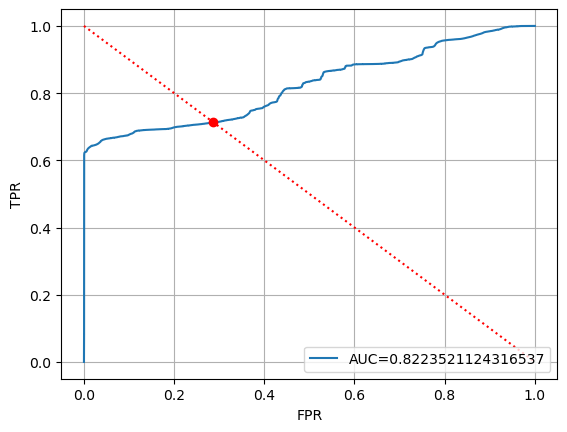

array([1.2954527], dtype=float32)

In [19]:
threshold = ROC(y_test,y_pred)
threshold

best: 1.816326530612245 F1: 0.763539032827989


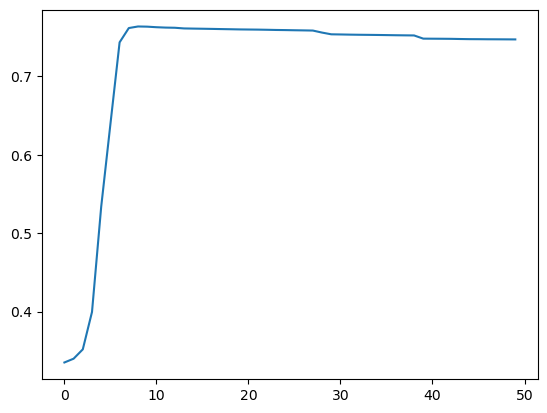

In [20]:
ff = 0
f_history = []
initial_y = 1
best = -1
for inc in np.linspace(0, 5, 50):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

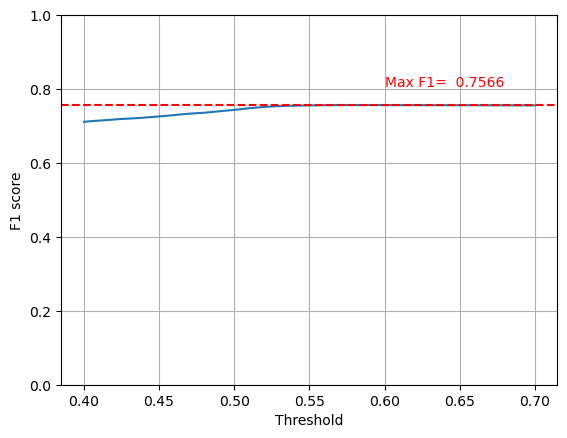

In [36]:
x_vals = 0.4 + np.linspace(0, 0.3, 50)
plt.plot(x_vals, f_history)
plt.xlabel('Threshold')
plt.ylabel('F1 score')

max_y = max(f_history)
max_x = np.argmax(f_history)
plt.axhline(y=max_y, color='r', linestyle='--', label='Max Y')
plt.text(0.6, max_y + 0.05, f'Max F1= {max_y: .4f}', color='r')
plt.ylim(0, 1)
plt.grid(True)

# plt.savefig('my_plot.png')

plt.show()

In [33]:
y_pred_int = [1 if (yy > 0.46938775510204084) else 0 for yy in y_pred]
conf_matrix = confusion_matrix(y_test, y_pred_int)
TP = conf_matrix[1, 1]
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
F1 = f1_score(y_test, y_pred_int)

precision = precision_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", F1)
print(f'TP: {TP}\nTN: {TN}\nFP: {FP}\nFN: {FN}')

Precision: 0.6346748574674437
Recall: 0.49212097484584516
F1 Score: 0.5543804842192309
TP: 30168
TN: 371052
FP: 17365
FN: 31134
